Scenario:

Beta Bank customers are leaving and we've been asked to predict whether a customer will leave the bank soon using data on clients’ past behavior and termination of contracts with the bank.

<a class="anchor" id="table_of_contents">Overall Plan / Table of Contents</a>

- [Download and prepare the data](#prepare_data)
- [Change data types](#datatypes)
- [One hot encoding](#ohe)
- [Divide dataframes into 3 groups](#split)
- [Examine the balance of classes](#balance)
- [Write print scores function](#scorefx)
- [Train the model without balance adjustments](#unbalanced)
- [Train different models and find the best one](#bestmodel)
- [Build a model with the maximum possible F1 score (at least 0.59)](#f1)
- [Perform final testing where F1 score >= 0.59](#testing)
- [Measure the AUC ROC metric and compare it with F1](#aucroc)

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-

Target: Exited — сustomer has left

Question: Predict if a customer will leave the bank

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle 
from sklearn.metrics import roc_curve
import random
import time


# import sys and insert code to ignore warnings 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="prepare_data">Download and prepare the data</a>

In [2]:
# load the data 
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    print('ERROR: Unable to find or access file.')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# check columns, rows
df.shape

(10000, 14)

In [4]:
# check for duplicates
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [5]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# print composition of data types
df.dtypes.value_counts()

int64      8
object     3
float64    3
dtype: int64

In [7]:
# check for na values
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [8]:
# check general statistics for dataFrame
print('Statistics')
df.describe().T

Statistics


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


We note:
- The file contains 10000 rows and 14 columns
- There are no duplicated rows
- Tenure column is missing 909 rows
- Data types: 8 int64, 3 object, 3 float64 
- Columns: 
        - RowNumber — data string index
        - CustomerId — unique customer identifier
        - Surname — surname
        - CreditScore — credit score
        - Geography — country of residence
        - Gender — gender
        - Age — age
        - Tenure — period of maturation for a customer’s fixed deposit (years)
        - Balance — account balance
        - NumOfProducts — number of banking products used by the customer
        - HasCrCard — customer has a credit card
        - IsActiveMember — customer’s activeness
        - EstimatedSalary — estimated salary

Next steps:
- Change column names to lower case
- Assess if all columns are relavant to the analysis
- Correct datatypes as needed
- Investigate Tenure column's missing rows
- Address columns (where is OHE appropriate?)
- Address columns (where is label encoding appropriate?)

In [9]:
# Map the lowering function to all column names
df.columns = map(str.lower, df.columns)
df.head(1)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


In [10]:
# verify customerid is unique for every user
print('Number of unique customerid values:', df.customerid.nunique())

Number of unique customerid values: 10000


Are all columns relevant? rownumber simply indexes the customers, starting at one, so this may not be useful. customerid is also not useful, as every row corresponds to a unique customer already. surname could be useful if it identified familial relationships and family may influence each other to switch banks. But in a pool of 10000 individuals how can one identify relationships? We will investigate it further, but will likely drop surname.

creditscore, geography, gender, age, tenure, balance, numofproducts, hasccard, isactivemember, and estimatedsalary are all useful features. We will investigate surname to see if it may be helpful for analysis.

In [11]:
# investigate surname column
print('Number of unique surnames', df.surname.nunique())
df.surname.value_counts()

Number of unique surnames 2932


Smith          32
Martin         29
Scott          29
Walker         28
Brown          26
               ..
Thynne          1
Hare            1
Bruny           1
Illingworth     1
Cockrum         1
Name: surname, Length: 2932, dtype: int64

We will drop the rownumber, customerid, and surname columns since we will not be using them for analysis. Then we investigate the tenure column.

In [12]:
# drop rownumber and surname from df
df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)
df.head(1)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


In [13]:
# check info once again to check datatypes
df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [14]:
# distribution of values for tenure column
df.tenure.value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [15]:
# explore missing values in tenure column
missing = df.tenure.isna().sum()
pct = missing/len(df)
print('Percent of total customers with a missing value in tenure = {:.2%}'.format(pct))
df[df.tenure.isna()].head()

Percent of total customers with a missing value in tenure = 9.09%


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In [16]:
# investigate any correlations
df.corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
creditscore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


In [17]:
# examine the statistics of the tenure column
print('The mode for the tenure column:', df.tenure.mode())
df.tenure.describe().T

The mode for the tenure column: 0    1.0
dtype: float64


count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

We notice:
- Less than 10% of the total customers are missing the value for tenure. Removing those rows is a possibility
- There do not appear to be any correlations between tenure and other columns
- The mode, most common value, is 1.0
- The mean and median are quite close (4.99 and 5.0)

Since there are no obvious correlations and it is generally preferable to keep data instead of dropping it. 

We suspect the reason for the missing values is unknow. We will replace the missing values with the mean of tenure.

In [18]:
# replace missing values in tenure with mean
#df.tenure = df.tenure.fillna(df.tenure.mean())
print('Number of missing values in tenure after replacement:',
     df.tenure.isna().sum()
     )
df.tenure.describe().T

Number of missing values in tenure after replacement: 0


count    10000.00000
mean         4.99769
std          2.76001
min          0.00000
25%          3.00000
50%          4.99769
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

In [19]:
# will continue working on this in the future

# fill in the missing values in tenure with a randomly generated number

'''
limit = len(df)

# create a list of random numbers in range 0 to 10
#list = []
#for i in range(limit):
#    r=random.randint(0,10)
#    list.append(r)

# create a loop to fill NaN values with a number from the list
for i in range(limit):
    if np.isnan(df.tenure[i]) == True:  
        df['tenure'][i] = list[i]
    else:
         df.tenure[i] = df.tenure[i] 
df.tenure.value_counts()
'''

"\nlimit = len(df)\n\n# create a list of random numbers in range 0 to 10\n#list = []\n#for i in range(limit):\n#    r=random.randint(0,10)\n#    list.append(r)\n\n# create a loop to fill NaN values with a number from the list\nfor i in range(limit):\n    if np.isnan(df.tenure[i]) == True:  \n        df['tenure'][i] = list[i]\n    else:\n         df.tenure[i] = df.tenure[i] \ndf.tenure.value_counts()\n"

We've replaced the missing values in tenure and now we will address the data types for the columns.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="datatypes">**Change data types**</a>

In [20]:
# refresh our memory on current data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [21]:
# change/downcast datatypes as appropriate
# For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values)
# changing from object to category will help optimize memory and retrieval
# some of these could go to boolean instead, but will stick with integer as there doesn't seem a strong advantage

df.creditscore = pd.to_numeric(df.creditscore, downcast='integer')
df.geography = df.geography.astype('category')
df.gender = df.gender.astype('category')
df.age = pd.to_numeric(df.age, downcast='integer')
# since tenure is in years, we will change it to integer
df.tenure = df.tenure.apply(np.int)
df.tenure = df.tenure.astype('int16')
df.balance = pd.to_numeric(df.balance, downcast='float')
df.numofproducts = pd.to_numeric(df.numofproducts, downcast='integer')
df.hascrcard = pd.to_numeric(df.hascrcard, downcast='integer')
df.isactivemember  = pd.to_numeric(df.isactivemember, downcast='integer')
df.estimatedsalary = pd.to_numeric(df.estimatedsalary, downcast='float')
df.exited = pd.to_numeric(df.exited, downcast='integer')

# verify new data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int16
geography          10000 non-null category
gender             10000 non-null category
age                10000 non-null int8
tenure             10000 non-null int16
balance            10000 non-null float32
numofproducts      10000 non-null int8
hascrcard          10000 non-null int8
isactivemember     10000 non-null int8
estimatedsalary    10000 non-null float32
exited             10000 non-null int8
dtypes: category(2), float32(2), int16(2), int8(5)
memory usage: 185.9 KB


We've verified the new data types and note the reduced memory usage.

We note 2 columns with categorical information: geograpy and gender. We need a way to keep that information, but encode it.

One way is One Hot Encoding. It breaks the category into however many possible values and creates a new column for each possibility. One danger with OHE is the dummy trap, where the high correlation between all the columns can confuse the model. To avoid this, we drop the first column since its value may be inferred from the other columns. OHE isn't the best choice for tree-based models (decision trees, random forests) because the information gets lost as the algorithm travels deeper down the tree structure. 

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="ohe">**One hot encoding**</a>

In [22]:
# use OHE to break out the catgeorical columns

print('Distribution of geography column before encoding')
print(df.geography.value_counts())

print('Distribution of gender column before encoding')
print(df.gender.value_counts())

df_ohe = pd.get_dummies(df, drop_first = True)

# verify new columns
df_ohe.head()

Distribution of geography column before encoding
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
Distribution of gender column before encoding
Male      5457
Female    4543
Name: gender, dtype: int64


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.000000,1,1,1,101348.882812,1,0,0,0
1,608,41,1,83807.859375,1,0,1,112542.578125,0,0,1,0
2,502,42,8,159660.796875,3,1,0,113931.570312,1,0,0,0
3,699,39,1,0.000000,2,0,0,93826.632812,0,0,0,0
4,850,43,2,125510.820312,1,1,1,79084.101562,0,0,1,0


In [23]:
# check counts of new columns
print('Germany')
print(df_ohe.geography_Germany.value_counts())
print('Spain')
# check counts of new columns
print(df_ohe.geography_Spain.value_counts())
print('Male')
# check counts of new columns
print(df_ohe.gender_Male.value_counts())

Germany
0    7491
1    2509
Name: geography_Germany, dtype: int64
Spain
0    7523
1    2477
Name: geography_Spain, dtype: int64
Male
1    5457
0    4543
Name: gender_Male, dtype: int64


We've verfied our newly created columns and the numbers from the original df match with the new columns. 

Next we will divide the dataframes into 3 groups (train, valid, test) for our models.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="split">**Divide dataframes into 3 groups**</a>

In [24]:
# split dataframes into train, valid, test data sets (3:1:1)

# divide df into target and features
target_ohe = df_ohe['exited']
features_ohe = df_ohe.drop('exited', axis=1)

# divide df_ohe (train, valid, test)
target_ohe_train, target_ohe_valid = train_test_split(target_ohe, test_size=0.2, random_state=12345) 
target_ohe_train, target_ohe_test = train_test_split(target_ohe_train, test_size=0.25, random_state=12345)
print('Verify sizes of newly divided target_ohe_')
print('train valid test')
print(len(target_ohe_train), len(target_ohe_valid), len(target_ohe_test))

features_ohe_train, features_ohe_valid = train_test_split(features_ohe, test_size=0.2, random_state=12345) 
features_ohe_train, features_ohe_test = train_test_split(features_ohe_train, test_size=0.25, random_state=12345)
print('\nVerify sizes of newly divided features_ohe_')
print('train valid test')
print(len(features_ohe_train), len(features_ohe_valid), len(features_ohe_test))

Verify sizes of newly divided target_ohe_
train valid test
6000 2000 2000

Verify sizes of newly divided features_ohe_
train valid test
6000 2000 2000


We've verified the sizes of our dataframes are correct.

Now we briefly examine the balance of classes.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="balance">**Examine the balance of classes**</a>

In [25]:
# investigate balance of target in dataframes
print('Balance for df_ohe target (either 0 or 1)')
train_ohe_frequency = (target_ohe_train.value_counts(normalize=True) * 100).round(2)
valid_ohe_frequency = (target_ohe_valid.value_counts(normalize=True) * 100).round(2)
test_ohe_frequency = (target_ohe_test.value_counts(normalize=True) * 100).round(2)
print('% ohe Training Target balance of exited \n', train_ohe_frequency)
print('\n% ohe Validation Target balance of exited \n', valid_ohe_frequency)
print('\n% ohe Test Target balance of exited \n', test_ohe_frequency)

# https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html 

Balance for df_ohe target (either 0 or 1)
% ohe Training Target balance of exited 
 0    79.68
1    20.32
Name: exited, dtype: float64

% ohe Validation Target balance of exited 
 0    78.65
1    21.35
Name: exited, dtype: float64

% ohe Test Target balance of exited 
 0    80.45
1    19.55
Name: exited, dtype: float64


Our sample is imbalanced, about 80% of our target column indicates no exit, so if we use this unbalanced data for our models our accuracy will be skewed towards no exit. Our model is predicting 0 in every instance because of the unbalanced data.

We will first create a print_scores function to increase efficiency and then test unbalanced models.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="scorefx">**Write print scores function**</a>

In [26]:
# create efficient print_scores function
def print_scores(true, predicted):
    print('Precision: ' + str((precision_score(true, predicted)* 100).round(2)) + '%')
    print('Recall: ' + str((recall_score(true, predicted)* 100).round(2)) + '%')
    print('F1 Score: ' + str((f1_score(true, predicted) * 100).round(2)) + '%')
    print('Accuracy Score: ' + str((accuracy_score(true, predicted) * 100).round(2)) + '%')
    print('Balanced Accuracy Score: ' + str((balanced_accuracy_score(true, predicted) * 100).round(2)) + '%')
    print('ROC AUC score: ' + str((roc_auc_score(true, predicted) * 100).round(2)) + '%')   

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="unbalanced">**Train the model without balance adjustments**</a>

In [27]:
# use dummy method to find a baseline
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_ohe_train, target_ohe_train)
# use print_scores fx to get scores
print_scores(target_ohe_valid, dummy_clf.predict(features_ohe_valid))

Precision: 0.0%
Recall: 0.0%
F1 Score: 0.0%
Accuracy Score: 78.65%
Balanced Accuracy Score: 50.0%
ROC AUC score: 50.0%


In [28]:
# run a confusion matrix
confusion_matrix(target_ohe_valid, dummy_clf.predict(features_ohe_valid))

array([[1573,    0],
       [ 427,    0]])

As expected, our accuracy score is misleadingly high due to our unbalanced data. The F1 is actually zero, indicating a poorly performing model where either recall or precision or both are very low. In this case both precision and recall are 0.

The confusion matrix reveals many true positives, but almost 25% false positives. There are no true or false negatives. Our model is predicting 0 in every instance because of the unbalanced data.

Now we will begin building models that take the unbalanced data into account. We will begin with the simple linear model, and use a scaler to account for the different ranges (salary versus age for instance) of data. We don't want columns with larger numbers given more weight in the analysis.

**[Return to table of contents](#table_of_contents)**



<a class="anchor" id="bestmodel">**Train different models and find the best one**</a>

**Logistic Regression Linear Model**

In [29]:
# scale model for linear using ohe data
scaler = StandardScaler()
scaler.fit(features_ohe_train)
features_ohe_train_scaled = scaler.transform(features_ohe_train)
features_ohe_valid_scaled = scaler.transform(features_ohe_valid)

In [30]:
# create logistic regression model
lr = LogisticRegression(random_state=12345)
lr.fit(features_ohe_train_scaled, target_ohe_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
lr.predict(features_ohe_valid_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [32]:
print_scores(target_ohe_valid, lr.predict(features_ohe_valid_scaled))

Precision: 59.59%
Recall: 20.37%
F1 Score: 30.37%
Accuracy Score: 80.05%
Balanced Accuracy Score: 58.31%
ROC AUC score: 58.31%


In [33]:
# run a confusion matrix
confusion_matrix(target_ohe_valid, lr.predict(features_ohe_valid_scaled))

array([[1514,   59],
       [ 340,   87]])

The model shows improvements over the baseline. Our precision, recall, and F1 score all increased. The accuracy stayed about the same, but the balanced accuracy score and ROC AUC scores improved. The confusion matrix reveals fewer false positives and finally some negtives. There are more true negatives than false negatives, indicating improvement.

We will attempt to adjust for the unbalanced data by adding class_weight='balanced' to the linear regression initialization. 

In [34]:
# create logistic regression model using class_weight='balanced'
lr = LogisticRegression(random_state=12345, class_weight='balanced')
lr.fit(features_ohe_train_scaled, target_ohe_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
lr.predict(features_ohe_valid_scaled)
print_scores(target_ohe_valid, lr.predict(features_ohe_valid_scaled))
# run a confusion matrix
confusion_matrix(target_ohe_valid, lr.predict(features_ohe_valid_scaled))

Precision: 39.08%
Recall: 70.02%
F1 Score: 50.17%
Accuracy Score: 70.3%
Balanced Accuracy Score: 70.2%
ROC AUC score: 70.2%


array([[1107,  466],
       [ 128,  299]])

We observe a great increase in recall, F1 score, and the ROC AUC score. The accuracy score dropped, as did the precision. The confusion matrix shows an overall better distribution. However, the number of false negatives rose precipitiously. 

Next we will explore the decision tree classifier.

**Decision Tree Classifier**

In [36]:
# build decision tree model
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_ohe_train, target_ohe_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [37]:
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 51.18%
Recall: 50.82%
F1 Score: 51.0%
Accuracy Score: 79.15%
Balanced Accuracy Score: 68.83%
ROC AUC score: 68.83%


In [38]:
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

array([[1366,  207],
       [ 210,  217]])

We note even without balancing of classes, the F1 score is above 50%. The false positive and false negatives are still proportionally high. We will add class_weight=balanced to explore how this changes.

In [39]:
# build decision tree model
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_ohe_train, target_ohe_train)
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 53.03%
Recall: 49.18%
F1 Score: 51.03%
Accuracy Score: 79.85%
Balanced Accuracy Score: 68.68%
ROC AUC score: 68.68%


array([[1387,  186],
       [ 217,  210]])

Initializing class wight to balanced didn't change the metrics in any appreciable way. Next we will try random forest. It should have higher accuracy.

**Random Forest**

In [40]:
# build random forest model for encode data
model = RandomForestClassifier(random_state=12345)
model.fit(features_ohe_train, target_ohe_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [41]:
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 71.03%
Recall: 41.92%
F1 Score: 52.72%
Accuracy Score: 83.95%
Balanced Accuracy Score: 68.64%
ROC AUC score: 68.64%


array([[1500,   73],
       [ 248,  179]])

The F1 score is higher than in the other two models. Now we will add class_weight=balanced.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="f1">**Build a model with the maximum possible F1 score (at least 0.59)**</a>

In [42]:
# build random forest model 
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_ohe_train, target_ohe_train)
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 75.81%
Recall: 38.17%
F1 Score: 50.78%
Accuracy Score: 84.2%
Balanced Accuracy Score: 67.43%
ROC AUC score: 67.43%


array([[1521,   52],
       [ 264,  163]])

The F1 score actually went down. Next we will explore the optimal depth and n-estimators.

In [43]:
print('Accuracy for random forest classifier model\n')
print('What is the best max_depth?')
# print('max_depth                    F1 score')

# set up list for accuracy score
accuracy_list = []

# find the accuracy score when n_estimators is between 1 and 100
for n in range(1, 100):
        # notice need random_state=12345 here
        model = RandomForestClassifier(random_state=12345, class_weight ='balanced',
                                       max_depth = n) 

        # train the model/fit model 
        model.fit(features_ohe_train, target_ohe_train)
        
        # find the predictions using validation set 
        # notice not using score...
        predictions_valid = model.predict(features_ohe_valid)
        
        # calculate F1 score
        acc_score = f1_score(target_ohe_valid, predictions_valid)          
        
        # print n value and accuracy score
        # print("max_depth =", n, ": ", acc_score)        
        
        # add n value and accuracy score to list
        accuracy_list.append(acc_score)
        
# find the max n_estimator and save it as best_n_estimator
max_accuracy = max(accuracy_list)

# add one to calculation because index begins at 0
best_max_depth = accuracy_list.index(max_accuracy) + 1

# print n_estimator and accuracy score
print("The best performing depth =", best_max_depth, ": ", max_accuracy)
print('')

Accuracy for random forest classifier model

What is the best max_depth?
The best performing depth = 10 :  0.6291618828932263



In [44]:
print('Accuracy for random forest classifier model\n')
print('What is the best n_estimators?')
#print('n_estimators           F1 score')

# set up list for accuracy score
accuracy_list = []

# find the accuracy score when n_estimators is between 50 and 250
for n in range(1, 20):
        # notice need random_state=12345 here
        model = RandomForestClassifier(random_state=12345, class_weight ='balanced',
                                       n_estimators = n) 

        # train the model/fit model 
        model.fit(features_ohe_train, target_ohe_train)
        
        # find the predictions using validation set 
        # notice not using score...
        predictions_valid = model.predict(features_ohe_valid)
        
        # calculate F1 score
        acc_score = f1_score(target_ohe_valid, predictions_valid)      
        
        # calculate accuracy score
        #acc_score = accuracy_score(target_encode_valid, predictions_valid)      
        
        # print n value and accuracy score
        # print("n_estimators =", n, ": ", acc_score)        
        
        # add n value and accuracy score to list
        accuracy_list.append(acc_score)
        
# find the max n_estimator and save it as best_n_estimator
max_accuracy = max(accuracy_list)

# add one to calculation because index begins at 0
best_n_estimator = accuracy_list.index(max_accuracy) + 1

# print n_estimator and accuracy score
print("The best performing n_estimators =", best_n_estimator, ": ", max_accuracy)
print('')

Accuracy for random forest classifier model

What is the best n_estimators?
The best performing n_estimators = 13 :  0.550595238095238



In [45]:
# build random forest model using best max_depth, n_estimators
model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                              max_depth = 10, n_estimators = 17)
model.fit(features_ohe_train, target_ohe_train)
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 64.17%
Recall: 64.17%
F1 Score: 64.17%
Accuracy Score: 84.7%
Balanced Accuracy Score: 77.22%
ROC AUC score: 77.22%


array([[1420,  153],
       [ 153,  274]])

Here we have the highest F1 score yet, well above the 59% threshold. Finally, let's unsample the target data and see if we can improve the F1 score.

In [46]:
# upsample target data

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target ==1]

    return features_upsampled, target_upsampled

features_zeros = features_ohe_train[target_ohe_train == 0]
features_ones = features_ohe_train[target_ohe_train == 1]
target_zeros = target_ohe_train[target_ohe_train == 0]
target_ones = target_ohe_train[target_ohe_train == 1]

repeat = 10
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

features_upsampled, target_upsampled = upsample(
    features_ohe_train, target_ohe_train, 10
)

# print(features_upsampled.shape)
# print(target_upsampled.shape)

# shuffle the unsampled
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345) 

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(
    features_ohe_train, target_ohe_train, 10
)

model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                              max_depth = 10, n_estimators = 17)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_ohe_valid)

# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 56.17%
Recall: 69.32%
F1 Score: 62.05%
Accuracy Score: 81.9%
Balanced Accuracy Score: 77.32%
ROC AUC score: 77.32%


array([[1342,  231],
       [ 131,  296]])

Upsampling actually decreased our F1 score. We will continue go back to using the previous model.

Finally we have a model we can test. The F1 score is well above the 59% threshold, the accuracy score is above the baseline we tested initially, and the confusion matrix demonstrates a greater number of true positives/negatives than the negative postives/negatives. 

We will use our test data to verify.

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="testing">**Perform final testing where F1 score >= 0.59**</a>

In [47]:
# build random forest model using best max_depth, n_estimators
model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                              max_depth = 10, n_estimators = 17)
model.fit(features_ohe_train, target_ohe_train)
# display scores
print_scores(target_ohe_valid, model.predict(features_ohe_valid))
# run a confusion matrix
confusion_matrix(target_ohe_valid, model.predict(features_ohe_valid))

Precision: 64.17%
Recall: 64.17%
F1 Score: 64.17%
Accuracy Score: 84.7%
Balanced Accuracy Score: 77.22%
ROC AUC score: 77.22%


array([[1420,  153],
       [ 153,  274]])

In [48]:
# display scores
print_scores(target_ohe_test, model.predict(features_ohe_test))
# run a confusion matrix
confusion_matrix(target_ohe_test, model.predict(features_ohe_test))

Precision: 58.33%
Recall: 60.87%
F1 Score: 59.57%
Accuracy Score: 83.85%
Balanced Accuracy Score: 75.15%
ROC AUC score: 75.15%


array([[1439,  170],
       [ 153,  238]])

We find the F1 score is over 59% for the test data, indicating the high correlation between precision and recall. The accuracy score is above the baseline, not by much, but some. The ROC AUC score is pretty robust. A ROC of 50% indicates a model created by chance. 

**[Return to table of contents](#table_of_contents)**

<a class="anchor" id="aucroc">Measure the AUC ROC metric and compare it with F1</a>

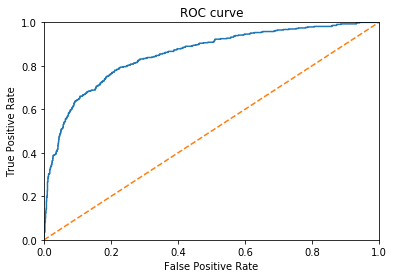

In [49]:
probabilities_valid = model.predict_proba(features_ohe_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# notice used probabilities_one_valid
fpr, tpr, thresholds = roc_curve(target_ohe_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
# < plot the graph >

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# use the functions plt.xlabel() and plt.ylabel() to
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# add the heading "ROC curve" with the function plt.title() 
plt.title('ROC curve')
plt.show()

The ROC curve indicates our model will consistently predict those customers who will stay with the bank and those that likely to move on. While not perfect, our model is far better than chance. We recommend using the random forest classification with weighted balance in this situation.

References

- [Downcasting data types and memory](https://hackersandslackers.com/downcast-numerical-columns-python-pandas/)